In [1]:
import math
from pathlib import Path
import sys
import numpy as np
import pandas as pd
from scipy import stats
import statistics

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans,DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
#import TCRemb_code2
#import TCRemb_code3
import TCRemb
import ml_utils
import data_proc

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [3]:
import warnings
warnings.filterwarnings('ignore')

# Paths

In [4]:
run_name = 'vdjdb_071223'
raw_train_data_path = 'mirpy/notebooks/assets/vdjdb.slim.txt'

In [5]:
label = 'antigen.epitope'
label_s = 'antigen.species'
tcr_columns = {'single': ['cdr3','v','j','chain'],'paired': {'TRA': ['a_cdr3', 'TRAV', 'TRAJ'],'TRB': [ 'b_cdr3', 'TRBV', 'TRBJ']}}
tcr_columns = ['cdr3','v','j','chain']
clonotype_id_column = 'cloneId'
data_id= 'data_id'
annotation_id = 'annotId'
pairing_id = 'barcode'
annotation_tcr_id_columns_dict = {'TRA': 'cloneId','TRB': 'cloneId','TRA_TRB': {'TRA':'cloneId_TRA', 'TRB':'cloneId_TRB'}}

In [6]:
outputs_path = "tcremb_outputs/" + run_name + '/'
Path(outputs_path).mkdir(parents=True, exist_ok=True)

In [7]:
data_path = outputs_path +'VDJdb_data.csv'

In [8]:
prototypes_path = { 'TRA' :'mirpy/notebooks/assets/olga_humanTRA_3000.txt', 'TRB' : 'mirpy/notebooks/assets/olga_humanTRB_3000.txt'}

In [9]:
clonotypes_path = { 'TRA' : outputs_path + 'clonotypes_TRA.txt', 'TRB' : outputs_path + 'clonotypes_TRB.txt'}

In [10]:
res_path = {'TRA' : outputs_path + 'res_TRA.txt', 'TRB': outputs_path + 'res_TRB.txt'}

## rename cols

In [11]:
data = pd.read_csv(raw_train_data_path,sep='\t')
data = data.rename({'gene':'chain','v.segm':'v','j.segm':'j'},axis=1)
data.to_csv(data_path, sep = '\t',index=False)



## assign data_id and filtering, train

In [12]:
data = data_proc.annot_id(data, data_id)

In [13]:
data_preped = data_proc.remove_asterisk(data, tcr_columns)
data_preped = data_proc.remove_backslash(data_preped, tcr_columns)
data_preped = data_proc.filter_clones_data(data_preped, tcr_columns)
data_preped = data_preped[-data_preped['reference.id'].str.startswith('https://www.10xgenomics',na=False)].reset_index(drop=True)
data_preped = data_preped[data_preped['species']=='HomoSapiens']

(75280, 17)
(74240, 17)


In [14]:
data_preped.shape

(36193, 17)

In [15]:
label_high = str(label + '_high_count')

In [16]:
label_count = {str(label + '_high_count_10'):10,str(label + '_high_count_20'):20,str(label + '_high_count_30'):30,str(label + '_high_count_50'):50,str(label + '_high_count_100'):100,
                  str(label + '_high_count_200'):200, str(label + '_high_count_300'):300,str(label + '_high_count_500'):500,str(label + '_high_count_700'):700,str(label + '_high_count_1000'):1000}

In [17]:
## top tetramers with higher count
label_counts = data_preped.groupby(label)[data_id].count().sort_values().reset_index(name='counts')
label_high_count = list(label_counts[label_counts['counts']>=50][label])
data_preped[label_high] = data_preped[label].apply(lambda x: x if x in label_high_count else 'other')

In [18]:
label_high_count_dict = {}
for k in label_count.keys():
    label_high_count_dict[k] = list(label_counts[label_counts['counts']>= label_count[k]][label])
    data_preped[k] = data_preped[label].apply(lambda x: x if x in label_high_count_dict[k] else 'other')
    

In [19]:
len(label_high_count)

80

<Axes: xlabel='Count', ylabel='antigen.epitope_high_count_20'>

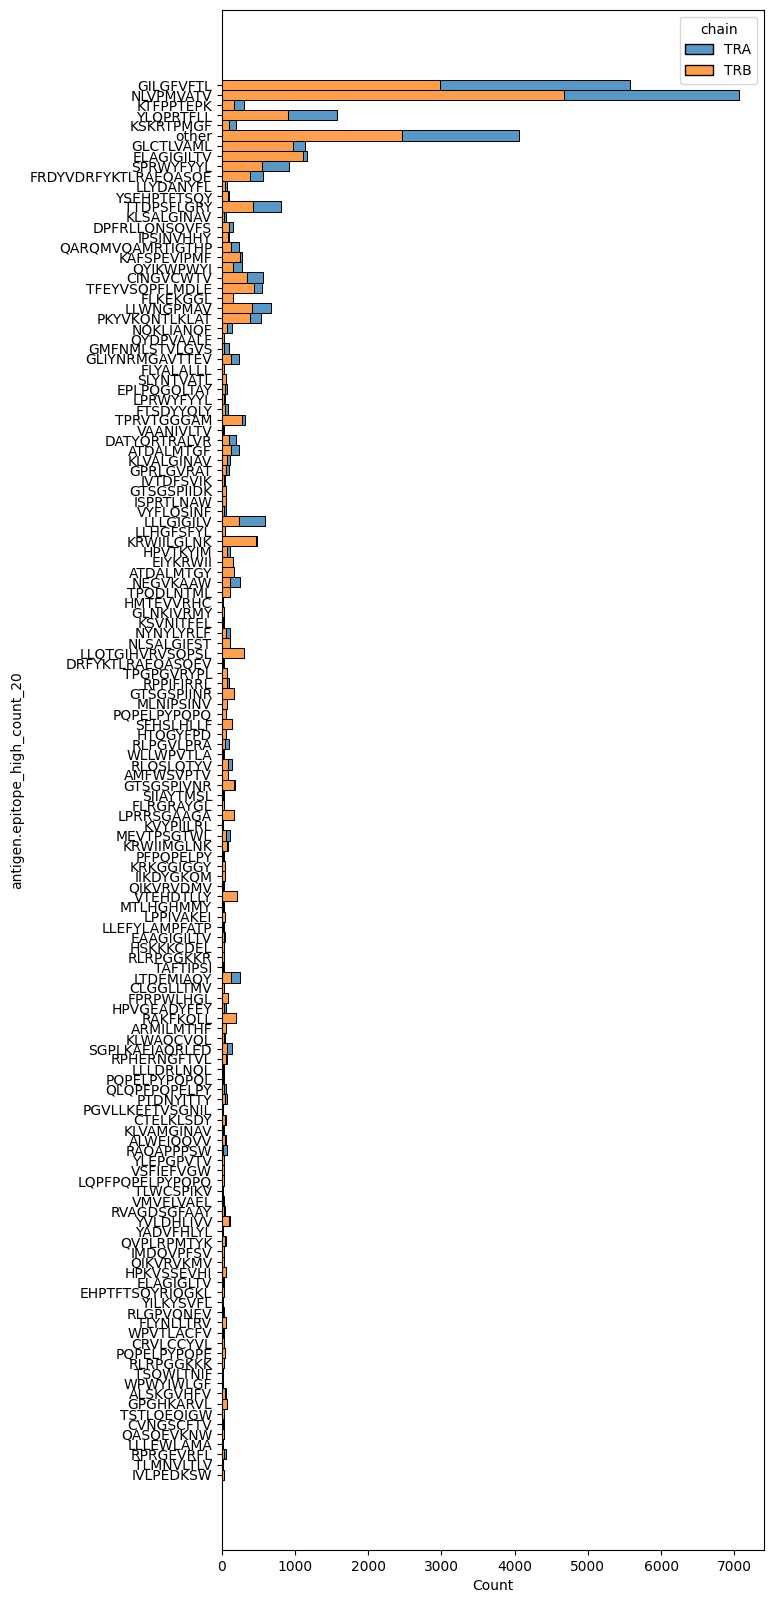

In [20]:
plt.figure(figsize=(7,20))
sns.histplot(data = data_preped, y = str(label+'_high_count_20'),hue='chain',multiple='stack')

<Axes: xlabel='Count', ylabel='antigen.epitope_high_count_200'>

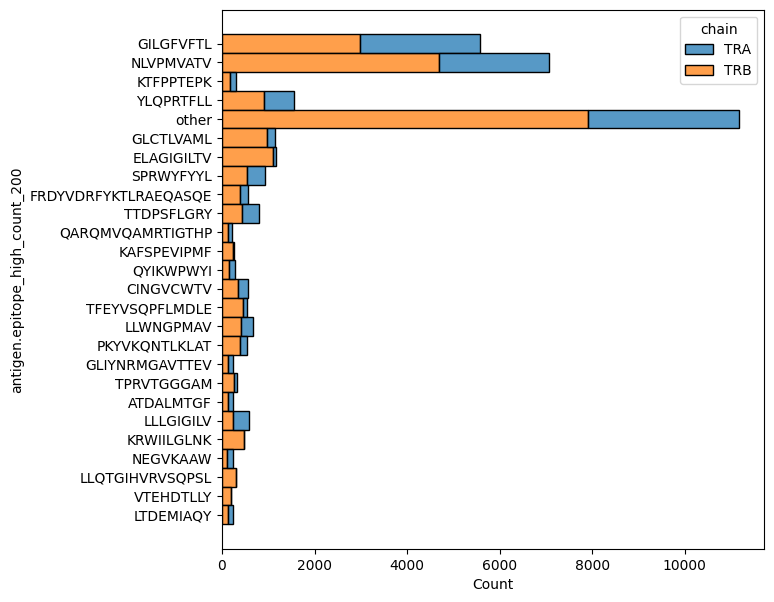

In [21]:
plt.figure(figsize=(7,7))
sns.histplot(data = data_preped, y = str(label+'_high_count_200'),hue='chain',multiple='stack',binwidth=1)

<Axes: xlabel='Count', ylabel='antigen.epitope_high_count_1000'>

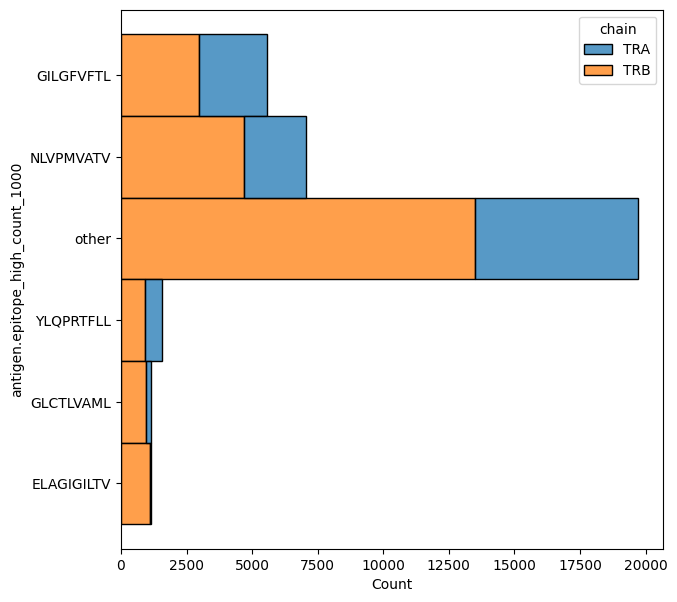

In [22]:
plt.figure(figsize=(7,7))
sns.histplot(data = data_preped, y = str(label+'_high_count_1000'),hue='chain',multiple='stack',binwidth=1)

In [23]:
label_high_s = str(label_s + '_high_count')
label_high_s_1000 = str(label_s + '_high_count_1000')

In [24]:

## top tetramers with higher count
label_counts_s = data_preped.groupby(label_s)[data_id].count().sort_values().reset_index(name='counts')
label_high_count_s = list(label_counts_s[label_counts_s['counts']>=100][label_s])
data_preped[label_high_s] = data_preped[label_s].apply(lambda x: x if x in label_high_count_s else 'other')

label_high_count_s = list(label_counts_s[label_counts_s['counts']>=1000][label_s])
data_preped[label_high_s_1000] = data_preped[label_s].apply(lambda x: x if x in label_high_count_s else 'other')

In [25]:
len(label_high_count_s)

7

<Axes: xlabel='Count', ylabel='antigen.species_high_count'>

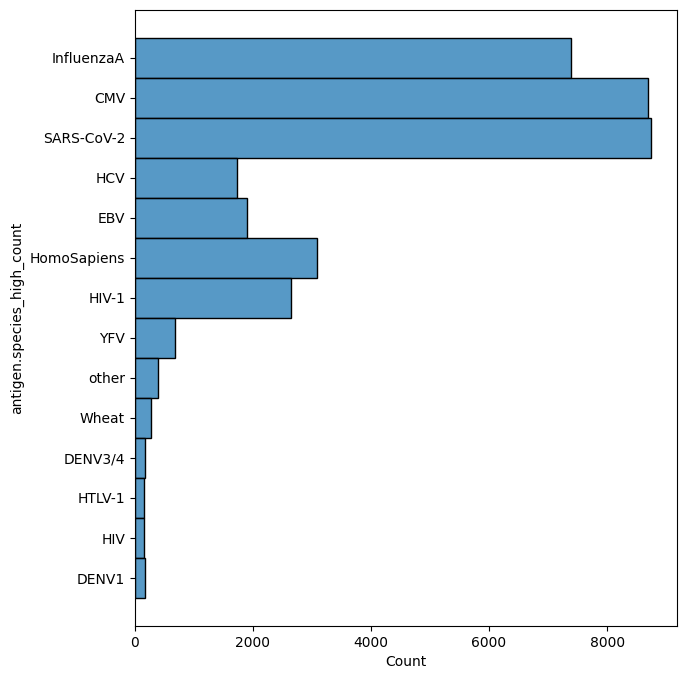

In [26]:
plt.figure(figsize=(7,8))
sns.histplot(y=data_preped[label_high_s])

# Try TCRemb module

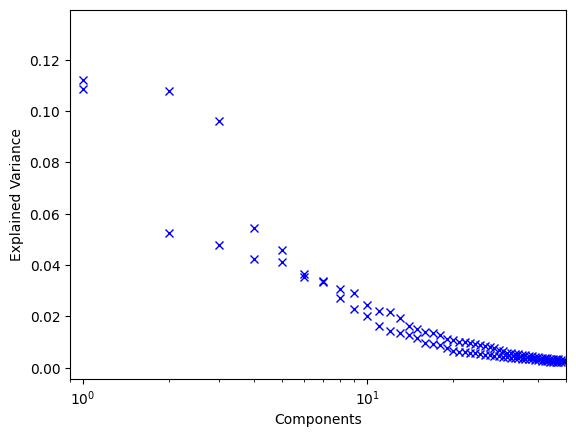

In [27]:
tcremb = TCRemb.TCRemb(run_name)
tcremb.tcremb_clonotypes('TRA',data_preped)
tcremb.tcremb_clonotypes('TRB',data_preped)
#tcremb.tcremb_dists_count('TRA')
#tcremb.tcremb_dists_count('TRB')
tcremb.tcremb_dists('TRA')
tcremb.tcremb_dists('TRB')
tcremb.tcremb_pca('TRA')
tcremb.tcremb_pca('TRB')
tcremb.tcremb_tsne('TRA')
tcremb.tcremb_tsne('TRB')

# Analysis

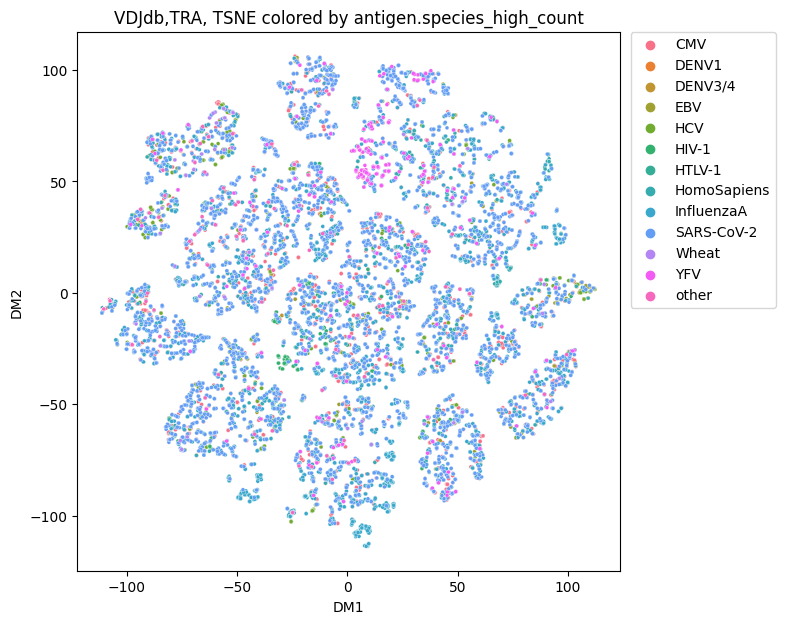

In [28]:
chain = 'TRA'
ml_utils.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), label_high_s, f'VDJdb,{chain}, TSNE colored by {label_high_s}')

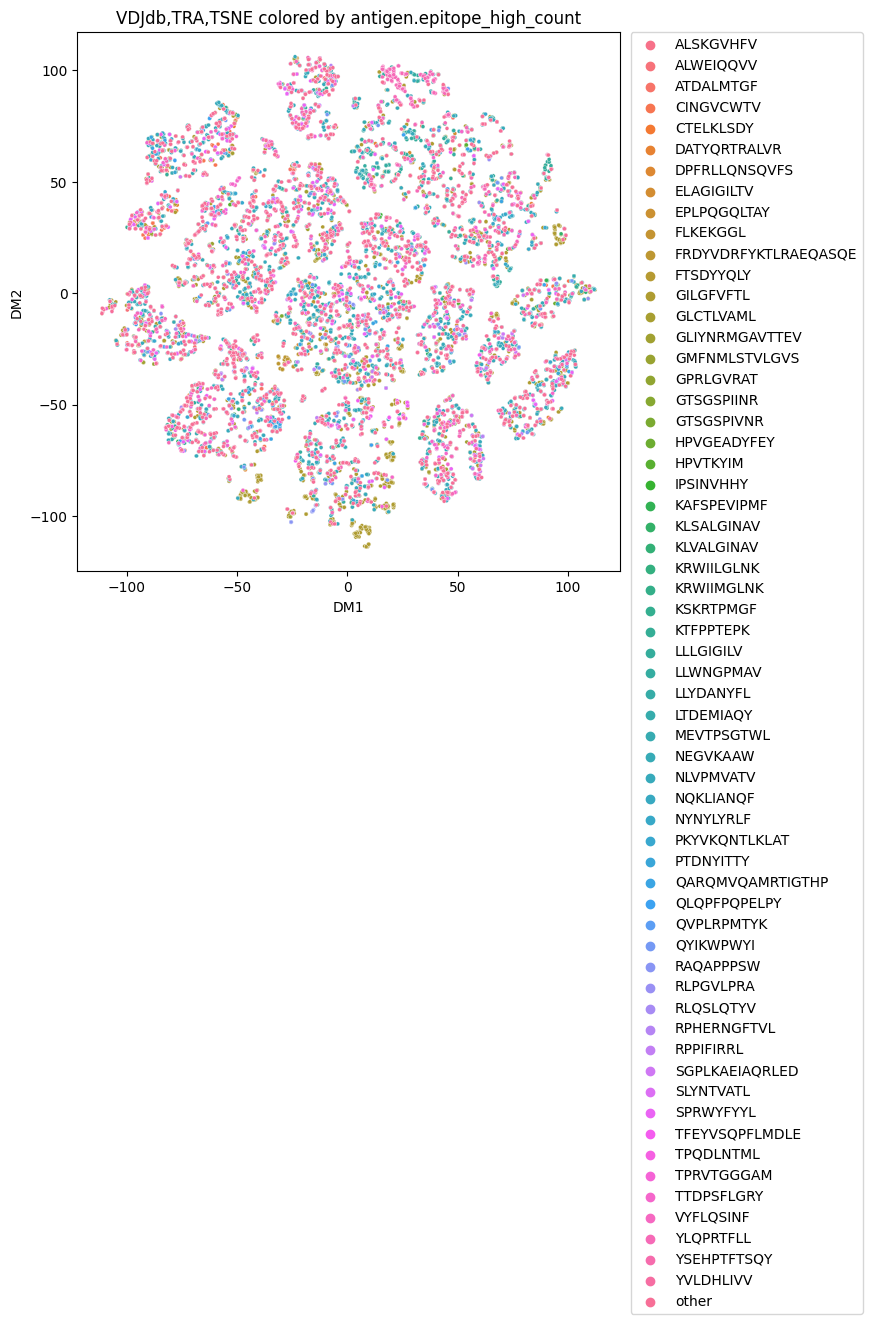

In [29]:
chain = 'TRA'
ml_utils.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]),  label_high, f'VDJdb,{chain},TSNE colored by {label_high}')

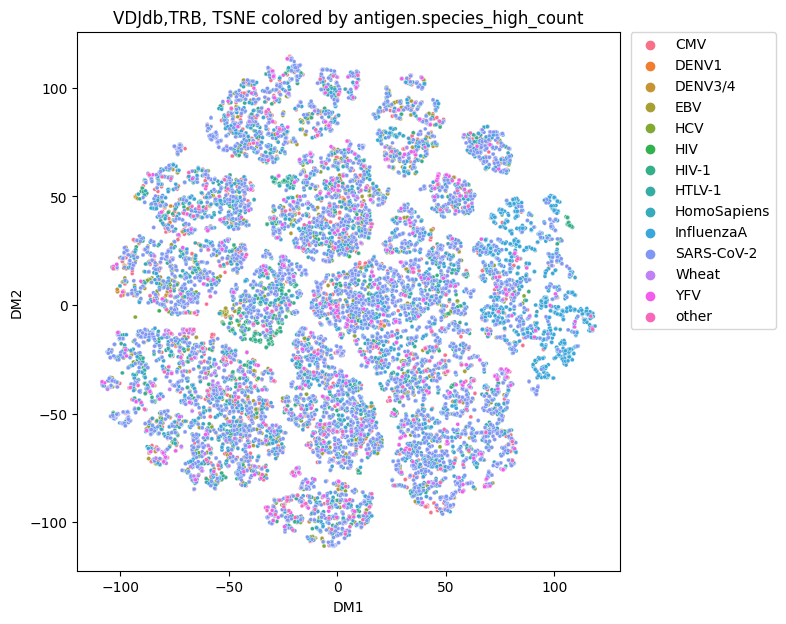

In [30]:
chain = 'TRB'
ml_utils.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), label_high_s, f'VDJdb,{chain}, TSNE colored by {label_high_s}')

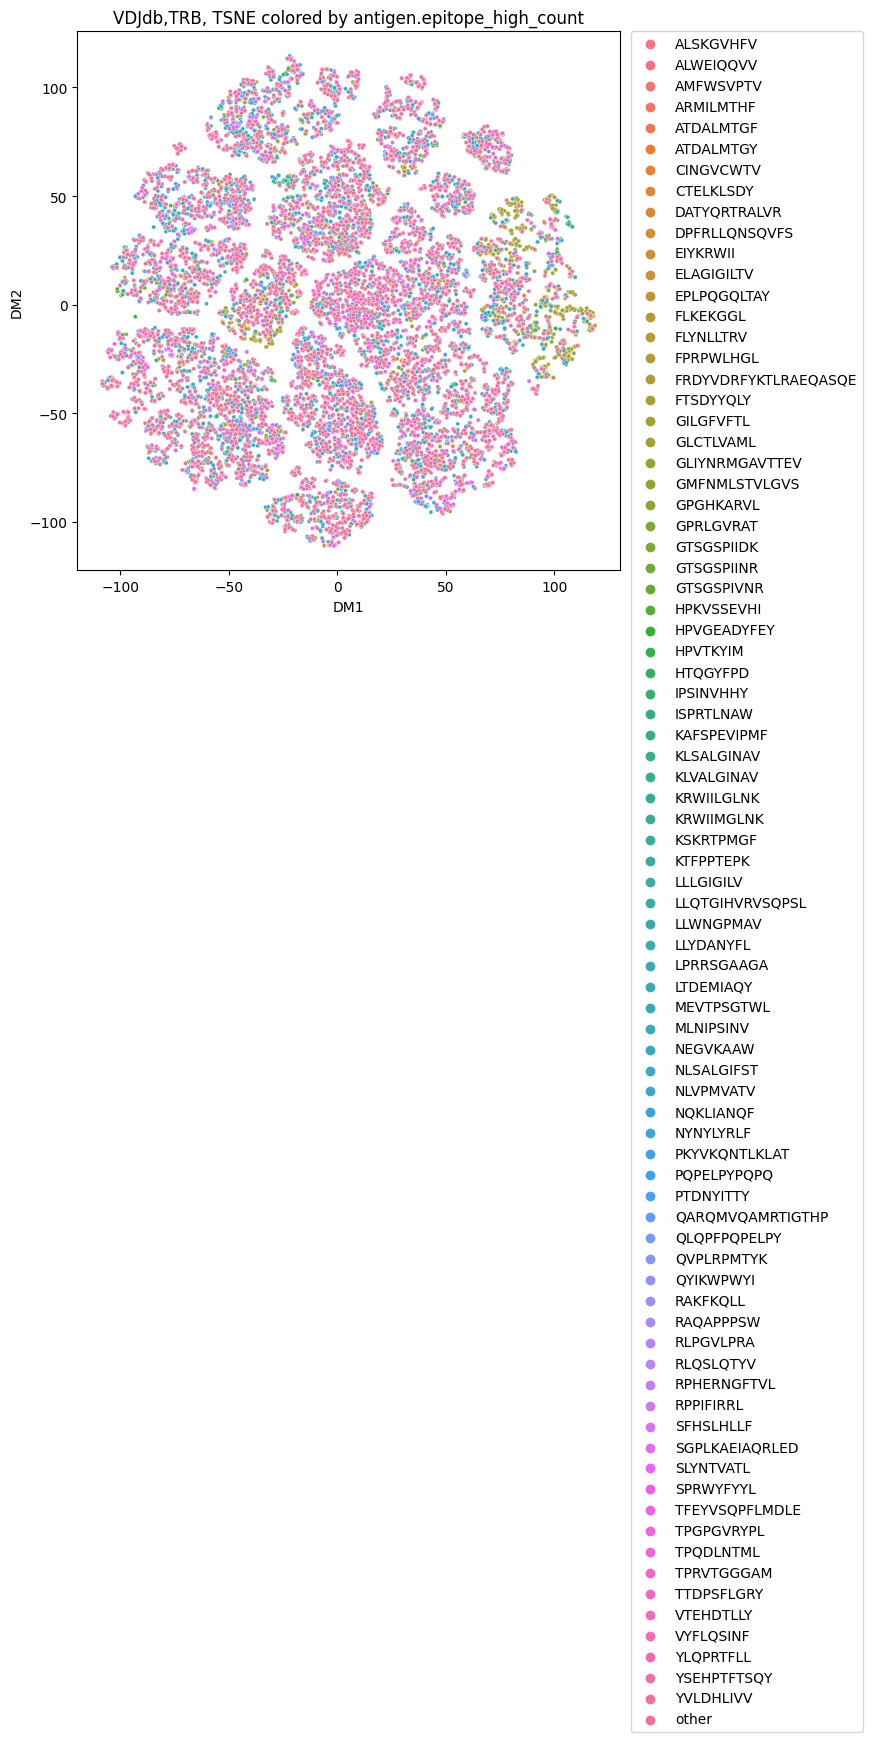

In [31]:
chain = 'TRB'
ml_utils.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), label_high, f'VDJdb,{chain}, TSNE colored by {label_high}')

## Clustering

### Evaluation

In [ ]:
clstr_scores_dict = {}

In [ ]:
evaluation_type = 'tunnining_all_labels'
clstr_scores_dict[evaluation_type]={}

In [ ]:
chain = 'TRA'
label_cl = label
y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain].drop(annotation_id, axis=1, errors = 'ignore')

data_len = len(y_data)

range_n_clusters = [round(data_len*0.005),round(data_len*0.01), round(data_len*0.05) , round(data_len*0.1), round(data_len*0.15)
                    ,round(data_len*0.2), round(data_len*0.25), round(data_len*0.3)
                    , round(data_len*0.4), round(data_len*0.5), round(data_len*0.6), round(data_len*0.7), round(data_len*0.8), round(data_len*0.9)]
    
comon_params = {'n_clusters' : range_n_clusters, 'n_neighbors': [2, 5, 10, 50]}
clstr_params = {
    'Agglomerativ':
    {'n_clusters': comon_params['n_clusters']*4,
     'linkage': ['average']*14 + ['complete']*14 + ['ward']*14 + ['single']*14,
     'connectivity': pd.Series(comon_params['n_neighbors'] * 14).apply(lambda x: TCRemb_code2.connectivity_kneighbors_graph(X_data, x))
    },
    'KMeans': 
    {'n_clusters': comon_params['n_clusters'],
     'random_state': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    },
    'Birch':
    {'n_clusters': comon_params['n_clusters']
    },
    'DBSCAN':
    {'eps': [0.2, 0.3, 0.4, 0.5 ,0.6, 0.7 ,0.8, 0.9]
    }
}
clstr_scores_dict[evaluation_type][chain] = TCRemb_code2.run_bench_clustering(y_data, X_data, clstr_params)

clstr_scores_dict[evaluation_type][chain] = pd.DataFrame(clstr_scores_dict[evaluation_type][chain])
clstr_scores_dict[evaluation_type][chain]['metrics_sum'] = clstr_scores_dict[evaluation_type][chain]['v_measure_score'] + clstr_scores_dict[evaluation_type][chain]['adjusted_rand_score'] + clstr_scores_dict[evaluation_type][chain]['adjusted_mutual_info_score']+ clstr_scores_dict[evaluation_type][chain]['silhouette_score']

for i in list(clstr_scores_dict[evaluation_type][chain].sort_values('metrics_sum').tail(10).index):
    print(pd.DataFrame(clstr_scores_dict[evaluation_type][chain]).iloc[i]['model'])
clstr_scores_dict[evaluation_type][chain].sort_values('metrics_sum').tail(10)

In [ ]:
chain = 'TRB'
y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain].drop(annotation_id, axis=1, errors = 'ignore')

data_len = len(y_data)

range_n_clusters = [round(data_len*0.005),round(data_len*0.01), round(data_len*0.05) , round(data_len*0.1), round(data_len*0.15)
                    ,round(data_len*0.2), round(data_len*0.25), round(data_len*0.3)
                    , round(data_len*0.4), round(data_len*0.5), round(data_len*0.6), round(data_len*0.7), round(data_len*0.8), round(data_len*0.9)]
    
comon_params = {'n_clusters' : range_n_clusters, 'n_neighbors': [2, 5, 10, 50]}
clstr_params = {
    'Agglomerativ':
    {'n_clusters': comon_params['n_clusters']*4,
     'linkage': ['average']*14 + ['complete']*14 + ['ward']*14 + ['single']*14,
     'connectivity': pd.Series(comon_params['n_neighbors'] * 14).apply(lambda x: TCRemb_code2.connectivity_kneighbors_graph(X_data, x))
    },
    'KMeans': 
    {'n_clusters': comon_params['n_clusters'],
     'random_state': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    },
    'Birch':
    {'n_clusters': comon_params['n_clusters']
    },
    'DBSCAN':
    {'eps': [0.2, 0.3, 0.4, 0.5 ,0.6, 0.7 ,0.8, 0.9]
    }
}
clstr_scores_dict[evaluation_type][chain] = TCRemb_code2.run_bench_clustering(y_data, X_data, clstr_params)

clstr_scores_dict[evaluation_type][chain] = pd.DataFrame(clstr_scores_dict[evaluation_type][chain])
clstr_scores_dict[evaluation_type][chain]['metrics_sum'] = clstr_scores_dict[evaluation_type][chain]['v_measure_score'] + clstr_scores_dict[evaluation_type][chain]['adjusted_rand_score'] + clstr_scores_dict[evaluation_type][chain]['adjusted_mutual_info_score']+ clstr_scores_dict[evaluation_type][chain]['silhouette_score']

for i in list(clstr_scores_dict[evaluation_type][chain].sort_values('metrics_sum').tail(10).index):
    print(pd.DataFrame(clstr_scores_dict[evaluation_type][chain]).iloc[i]['model'])
clstr_scores_dict[evaluation_type][chain].sort_values('metrics_sum').tail(10)

In [ ]:
evaluation_type = 'tunnining_label_high'
clstr_scores_dict[evaluation_type]={}

In [ ]:
chain = 'TRA'
label_cl = label_high
y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain].drop(annotation_id, axis=1, errors = 'ignore')

data_len = len(y_data)

range_n_clusters = [round(data_len*0.005),round(data_len*0.01), round(data_len*0.05) , round(data_len*0.1), round(data_len*0.15)
                    ,round(data_len*0.2), round(data_len*0.25), round(data_len*0.3)
                    , round(data_len*0.4), round(data_len*0.5), round(data_len*0.6), round(data_len*0.7), round(data_len*0.8), round(data_len*0.9)]
    
comon_params = {'n_clusters' : range_n_clusters, 'n_neighbors': [2, 5, 10, 50]}
clstr_params = {
    'Agglomerativ':
    {'n_clusters': comon_params['n_clusters']*4,
     'linkage': ['average']*14 + ['complete']*14 + ['ward']*14 + ['single']*14,
     'connectivity': pd.Series(comon_params['n_neighbors'] * 14).apply(lambda x: TCRemb_code2.connectivity_kneighbors_graph(X_data, x))
    },
    'KMeans': 
    {'n_clusters': comon_params['n_clusters'],
     'random_state': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    },
    'Birch':
    {'n_clusters': comon_params['n_clusters']
    },
    'DBSCAN':
    {'eps': [0.2, 0.3, 0.4, 0.5 ,0.6, 0.7 ,0.8, 0.9]
    }
}
clstr_scores_dict[evaluation_type][chain] = TCRemb_code2.run_bench_clustering(y_data, X_data, clstr_params)

clstr_scores_dict[evaluation_type][chain] = pd.DataFrame(clstr_scores_dict[evaluation_type][chain])
clstr_scores_dict[evaluation_type][chain]['metrics_sum'] = clstr_scores_dict[evaluation_type][chain]['v_measure_score'] + clstr_scores_dict[evaluation_type][chain]['adjusted_rand_score'] + clstr_scores_dict[evaluation_type][chain]['adjusted_mutual_info_score']+ clstr_scores_dict[evaluation_type][chain]['silhouette_score']

for i in list(clstr_scores_dict[evaluation_type][chain].sort_values('metrics_sum').tail(10).index):
    print(pd.DataFrame(clstr_scores_dict[evaluation_type][chain]).iloc[i]['model'])
clstr_scores_dict[evaluation_type][chain].sort_values('metrics_sum').tail(10)

In [ ]:
chain = 'TRB'
label_cl = label_high
y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain].drop(annotation_id, axis=1, errors = 'ignore')

data_len = len(y_data)

range_n_clusters = [round(data_len*0.005),round(data_len*0.01), round(data_len*0.05) , round(data_len*0.1), round(data_len*0.15)
                    ,round(data_len*0.2), round(data_len*0.25), round(data_len*0.3)
                    , round(data_len*0.4), round(data_len*0.5), round(data_len*0.6), round(data_len*0.7), round(data_len*0.8), round(data_len*0.9)]
    
comon_params = {'n_clusters' : range_n_clusters, 'n_neighbors': [2, 5, 10, 50]}
clstr_params = {
    'Agglomerativ':
    {'n_clusters': comon_params['n_clusters']*4,
     'linkage': ['average']*14 + ['complete']*14 + ['ward']*14 + ['single']*14,
     'connectivity': pd.Series(comon_params['n_neighbors'] * 14).apply(lambda x: TCRemb_code2.connectivity_kneighbors_graph(X_data, x))
    },
    'KMeans': 
    {'n_clusters': comon_params['n_clusters'],
     'random_state': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    },
    'Birch':
    {'n_clusters': comon_params['n_clusters']
    },
    'DBSCAN':
    {'eps': [0.2, 0.3, 0.4, 0.5 ,0.6, 0.7 ,0.8, 0.9]
    }
}
clstr_scores_dict[evaluation_type][chain] = TCRemb_code2.run_bench_clustering(y_data, X_data, clstr_params)

clstr_scores_dict[evaluation_type][chain] = pd.DataFrame(clstr_scores_dict[evaluation_type][chain])
clstr_scores_dict[evaluation_type][chain]['metrics_sum'] = clstr_scores_dict[evaluation_type][chain]['v_measure_score'] + clstr_scores_dict[evaluation_type][chain]['adjusted_rand_score'] + clstr_scores_dict[evaluation_type][chain]['adjusted_mutual_info_score']+ clstr_scores_dict[evaluation_type][chain]['silhouette_score']

for i in list(clstr_scores_dict[evaluation_type][chain].sort_values('metrics_sum').tail(10).index):
    print(pd.DataFrame(clstr_scores_dict[evaluation_type][chain]).iloc[i]['model'])
clstr_scores_dict[evaluation_type][chain].sort_values('metrics_sum').tail(10)

### KMeans

In [28]:
kmeans = TCRemb.TCRemb_clustering('KMeans')

In [29]:
chain='TRA'
n_clusters = 5295
random_state = 8
model =  KMeans(n_clusters=n_clusters, random_state=random_state)
kmeans.clstr(chain,tcremb, label, model)

mean fraction_matched only clusters: 0.5667438498847591
median fraction_matched only clusters: 0.5
purity:0.565527950310559


In [30]:
chain='TRB'
n_clusters = 10616
random_state = 8
model =  KMeans(n_clusters=n_clusters, random_state=random_state)
kmeans.clstr(chain,tcremb, label,model)

mean fraction_matched only clusters: 0.5510949352566231
median fraction_matched only clusters: 0.5
purity:0.5550587501299782


<Axes: xlabel='fraction_matched', ylabel='Density'>

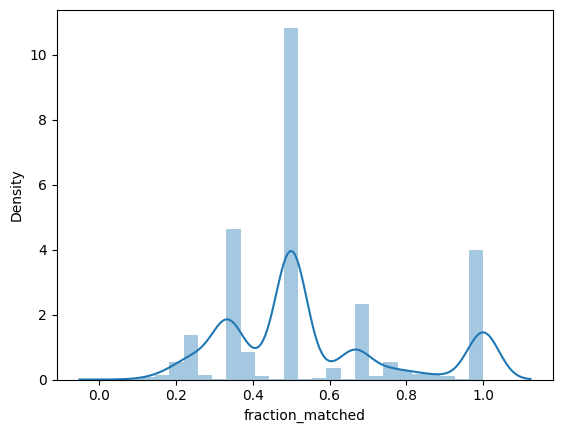

In [32]:
sns.distplot(kmeans.binom_res[chain][kmeans.binom_res[chain]['is_cluster']==1]['fraction_matched'])

In [37]:
kmeans.binom_res[chain][kmeans.binom_res[chain]['fraction_matched']==0.5]

,antigen.epitope,cluster,total_cluster,total_group,count_matched,fraction_matched,fraction_matched_exp,p_value,is_cluster,enriched_clstr
21199,WPWYIWLGF,599,2,14,1,0.5,0.000580,0.001160,1,0
4456,NLVPMVATV,6787,2,4672,1,0.5,0.193642,0.349787,1,0
24099,VAANIVLTV,5141,2,14,1,0.5,0.000580,0.001160,1,0
62,VAANIVLTV,9308,2,14,1,0.5,0.000580,0.001160,1,0
4953,WPWYIWLGF,5210,2,14,1,0.5,0.000580,0.001160,1,0
...,...,...,...,...,...,...,...,...,...,...
2140,FRDYVDRFYKTLRAEQASQE,1619,4,390,2,0.5,0.016164,0.001534,1,0
630,FRDYVDRFYKTLRAEQASQE,623,4,390,2,0.5,0.016164,0.001534,1,0
19184,FRDYVDRFYKTLRAEQASQE,4733,4,390,2,0.5,0.016164,0.001534,1,0
11027,FRDYVDRFYKTLRAEQASQE,5759,4,390,2,0.5,0.016164,0.001534,1,0


In [44]:
t = kmeans.clstr_labels[chain].merge(tcremb.annot[chain])
t[t['cluster']==599]

,cluster,annotId,label_cluster,total_cluster,total_group,count_matched,fraction_matched,fraction_matched_exp,p_value,is_cluster,...,antigen.epitope_high_count_50,antigen.epitope_high_count_100,antigen.epitope_high_count_200,antigen.epitope_high_count_300,antigen.epitope_high_count_500,antigen.epitope_high_count_700,antigen.epitope_high_count_1000,antigen.species_high_count,antigen.species_high_count_1000,cloneId
17002,599,17016,WPWYIWLGF,2,14,1,0.5,0.00058,0.00116,1,...,other,other,other,other,other,other,other,SARS-CoV-2,SARS-CoV-2,25068
21199,599,21218,WPWYIWLGF,2,14,1,0.5,0.00058,0.00116,1,...,other,other,other,other,other,other,other,SARS-CoV-2,SARS-CoV-2,7295


In [ ]:
chain = 'TRA'
kmeans.clstrs_motif(tcremb, chain, 10)

In [ ]:
chain = 'TRB'
kmeans.clstrs_motif(tcremb, chain, 10)

In [31]:
kmeans_s = TCRemb.TCRemb_clustering('KMeans_s')
chain='TRA'
n_clusters = 5295
random_state = 8
model =  KMeans(n_clusters=n_clusters, random_state=random_state)
kmeans_s.clstr(chain,tcremb, label_s, model)

chain='TRB'
n_clusters = 10616
random_state = 8
model =  KMeans(n_clusters=n_clusters, random_state=random_state)
kmeans_s.clstr(chain,tcremb, label_s,model)

mean fraction_matched only clusters: 0.6585397028810982
median fraction_matched only clusters: 0.6
purity:0.6605590062111801
mean fraction_matched only clusters: 0.6249354168004122
median fraction_matched only clusters: 0.5
purity:0.6301861287303733


In [45]:
sns.distplot(kmeans_s.binom_res[chain][kmeans.binom_res[chain]['is_cluster']==1]['fraction_matched'])

'antigen.species'

In [ ]:
for e in label_high_count_dict['antigen.epitope_high_count_1000']:
    t = pd.merge(tcremb['tsne'][chain],tcremb['clstr_labels'][model_name][chain],on=annotation_id)
    t[e]=t['label_cluster'].apply(lambda x: x if x==e else 'other')
    TCRemb_code2.tsne_plot(t, e, f'10x ,{chain}', f'TSNE colored by {e}', True)

In [ ]:
for e in ['HPVGEADYFEY','HTQGYFPD','IPSINVHHY','FLYALALLL','PTDNYITTY']:
    t = pd.merge(tcremb['tsne'][chain],tcremb['clstr_labels'][model_name][chain],on=annotation_id)
    t[e]=t['label_cluster'].apply(lambda x: x if x==e else 'other')
    TCRemb_code2.tsne_plot(t, e, f'10x ,{chain}', f'TSNE colored by {e}', True)

In [ ]:
for e in label_high_count_dict['antigen.epitope_high_count_1000']:
    t = pd.merge(tcremb['tsne'][chain],tcremb['clstr_labels'][model_name][chain],on=annotation_id)
    t[e]=t['label_cluster'].apply(lambda x: x if x==e else 'other')
    TCRemb_code2.tsne_plot(t, e, f'10x ,{chain}', f'TSNE colored by {e}', True)

In [ ]:
sns.distplot(kmeans.binom_res[chain][kmeans.binom_res[chain]['is_cluster']==1]['fraction_matched'])

In [ ]:
sns.histplot(kmeans.clstr_labels[chain]['enriched_clstr'].astype(str))
plt.title('count of tcrs in enriched clusters')

## classification

### Evaluatiom

In [ ]:
clsf_scores_dict = {}
best_clsf_dict = {}
all_clsf_scores_dict = {}

In [ ]:
evaluation_type = 'tunnining_all_labels'
clsf_scores_dict[evaluation_type] = {'TRA': {}, 'TRB':{}}
best_clsf_dict[evaluation_type] = {'TRA': {}, 'TRB':{}}
all_clsf_scores_dict[evaluation_type] = {'TRA': {}, 'TRB':{}}

In [ ]:

chain = 'TRA'
y_data = tcremb['annot'][chain][label]
X_data = tcremb['pca'][chain].drop(annotation_id, axis=1, errors = 'ignore')


common_params = {'param_range': [1, 2, 3, 4, 5, 6],
                 'param_range_2': [5, 7, 10, 15,20,25,30],
                 'param_range_3': [4, 5, 6, 7, 8],
                'n_estimators': [50,100,150]
                }

clsf_paramms = {
    #'KNN':
    #{'KNN__leaf_size':common_params['param_range_2'],
    # 'KNN__n_neighbors':common_params['param_range_3'],
    # 'KNN__weights':['uniform', 'distance']
    #},
    'AB':
    {'AB__n_estimators':common_params['n_estimators']
    },
    'SVM':
    {'SVM__C': common_params['param_range_3'],
    'SVM__kernel':[ 'poly','rbf']
    },
    'RF':
    {'RF__min_samples_leaf': common_params['param_range'],
    'RF__max_depth': common_params['param_range_2'], 
    'RF__min_samples_split':common_params['param_range'][1:],
     'RF__n_estimators':common_params['n_estimators']
    }, 
    'LR':
    {'LR__C':common_params['param_range'],
     'LR__multi_class': ['ovr'],
     'LR__max_iter': [10000]
    },
}

    
y_train, y_test,X_train, X_test,  = train_test_split(y_data, X_data ,test_size=0.3)
best_clsf_dict[evaluation_type][chain], clsf_scores_dict[evaluation_type][chain], all_clsf_scores_dict[evaluation_type][chain] = TCRemb_code2.clf_evaluate_models(X_train, y_train, X_test, y_test, clsf_paramms,n_splits=5, scoring_func='f1_weighted', debug=True)    


In [ ]:

chain = 'TRB'
y_data = tcremb['annot'][chain][label]
X_data = tcremb['pca'][chain].drop(annotation_id, axis=1, errors = 'ignore')


common_params = {'param_range': [1, 2, 3, 4, 5, 6],
                 'param_range_2': [5, 7, 10, 15,20,25,30],
                 'param_range_3': [4, 5, 6, 7, 8],
                'n_estimators': [50,100,150]
                }

clsf_paramms = {
    #'KNN':
    #{'KNN__leaf_size':common_params['param_range_2'],
    # 'KNN__n_neighbors':common_params['param_range_3'],
    # 'KNN__weights':['uniform', 'distance']
    #},
    'AB':
    {'AB__n_estimators':common_params['n_estimators']
    },
    'SVM':
    {'SVM__C': common_params['param_range_3'],
    'SVM__kernel':[ 'poly','rbf']
    },
    'RF':
    {'RF__min_samples_leaf': common_params['param_range'],
    'RF__max_depth': common_params['param_range_2'], 
    'RF__min_samples_split':common_params['param_range'][1:],
     'RF__n_estimators':common_params['n_estimators']
    }, 
    'LR':
    {'LR__C':common_params['param_range'],
     'LR__multi_class': ['ovr'],
     'LR__max_iter': [10000]
    },
}

    
y_train, y_test,X_train, X_test,  = train_test_split(y_data, X_data ,test_size=0.3)
best_clsf_dict[evaluation_type][chain], clsf_scores_dict[evaluation_type][chain], all_clsf_scores_dict[evaluation_type][chain] = TCRemb_code2.clf_evaluate_models(X_train, y_train, X_test, y_test, clsf_paramms,n_splits=5, scoring_func='f1_weighted', debug=True)    


In [ ]:
evaluation_type = 'tunnining_label_high'
clsf_scores_dict[evaluation_type] = {'TRA': {}, 'TRB':{}}
best_clsf_dict[evaluation_type] = {'TRA': {}, 'TRB':{}}
all_clsf_scores_dict[evaluation_type] = {'TRA': {}, 'TRB':{}}

In [ ]:

chain = 'TRA'
label_cl = label_high
y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain].drop(annotation_id, axis=1, errors = 'ignore')


common_params = {'param_range': [1, 2, 3, 4, 5, 6],
                 'param_range_2': [5, 7, 10, 15,20,25,30],
                 'param_range_3': [4, 5, 6, 7, 8],
                'n_estimators': [50,100,150]
                }

clsf_paramms = {
    #'KNN':
    #{'KNN__leaf_size':common_params['param_range_2'],
    # 'KNN__n_neighbors':common_params['param_range_3'],
    # 'KNN__weights':['uniform', 'distance']
    #},
    'AB':
    {'AB__n_estimators':common_params['n_estimators']
    },
    'SVM':
    {'SVM__C': common_params['param_range_3'],
    'SVM__kernel':[ 'poly','rbf']
    },
    'RF':
    {'RF__min_samples_leaf': common_params['param_range'],
    'RF__max_depth': common_params['param_range_2'], 
    'RF__min_samples_split':common_params['param_range'][1:],
     'RF__n_estimators':common_params['n_estimators']
    }, 
    'LR':
    {'LR__C':common_params['param_range'],
     'LR__multi_class': ['ovr'],
     'LR__max_iter': [10000]
    },
}

    
y_train, y_test,X_train, X_test,  = train_test_split(y_data, X_data ,test_size=0.3)
best_clsf_dict[evaluation_type][chain], clsf_scores_dict[evaluation_type][chain], all_clsf_scores_dict[evaluation_type][chain] = TCRemb_code2.clf_evaluate_models(X_train, y_train, X_test, y_test, clsf_paramms,n_splits=5, scoring_func='f1_weighted', debug=True)    


In [ ]:

chain = 'TRB'
label_cl = label_high
y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain].drop(annotation_id, axis=1, errors = 'ignore')


common_params = {'param_range': [1, 2, 3, 4, 5, 6],
                 'param_range_2': [5, 7, 10, 15,20,25,30],
                 'param_range_3': [4, 5, 6, 7, 8],
                'n_estimators': [50,100,150]
                }

clsf_paramms = {
    #'KNN':
    #{'KNN__leaf_size':common_params['param_range_2'],
    # 'KNN__n_neighbors':common_params['param_range_3'],
    # 'KNN__weights':['uniform', 'distance']
    #},
    'AB':
    {'AB__n_estimators':common_params['n_estimators']
    },
    'SVM':
    {'SVM__C': common_params['param_range_3'],
    'SVM__kernel':[ 'poly','rbf']
    },
    'RF':
    {'RF__min_samples_leaf': common_params['param_range'],
    'RF__max_depth': common_params['param_range_2'], 
    'RF__min_samples_split':common_params['param_range'][1:],
     'RF__n_estimators':common_params['n_estimators']
    }, 
    'LR':
    {'LR__C':common_params['param_range'],
     'LR__multi_class': ['ovr'],
     'LR__max_iter': [10000]
    },
}

    
y_train, y_test,X_train, X_test,  = train_test_split(y_data, X_data ,test_size=0.3)
best_clsf_dict[evaluation_type][chain], clsf_scores_dict[evaluation_type][chain], all_clsf_scores_dict[evaluation_type][chain] = TCRemb_code2.clf_evaluate_models(X_train, y_train, X_test, y_test, clsf_paramms,n_splits=5, scoring_func='f1_weighted', debug=True)    


### RF

In [ ]:
clf = TCRemb.TCRemb_clf('RF__high_count_1000')
chain='TRA'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf.clf(chain,tcremb,model, str(label + '_high_count_1000'),model,test_size=0.15)

In [ ]:
chain='TRB'
max_depth = 20
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf.clf(chain,tcremb, str(label + '_high_count_1000'),model, test_size=0.15)

In [ ]:
clf.roc_auc('TRA')

In [ ]:
clf.roc_auc('TRB')

In [ ]:
from sklearn.model_selection import cross_val_score



In [ ]:
def clf_model(model, label_np, proc_df, annotation_id_column, chain, test_size = 0.3 ,show_legend=True, ax=None):
    
    y_train, y_test,X_train, X_test,  = train_test_split(label_np, proc_df.drop(annotation_id_column, axis=1, errors = 'ignore') ,test_size=test_size)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)   
    print(f'Train accuracy: {model.score(X_train,y_train)}')
    print(f'Test accuracy: {model.score(X_test,y_test)}')
    print(f"macro: {TCRemb_code2.clsf_metrics(pred,y_test,'macro')}")
    print(f"weighted: {TCRemb_code2.clsf_metrics(pred,y_test,'weighted')}")
    
    print(f'cross_val_score: {cross_val_score(model, proc_df.drop(annotation_id_column, axis=1, errors = "ignore"), label_np, cv=5, scoring="accuracy")}')
    print(f'cross_val_score f1_weighted: {cross_val_score(model, proc_df.drop(annotation_id_column, axis=1, errors = "ignore"), label_np, cv=5, scoring="f1_weighted")}')
    
    
    roc_auc_df = TCRemb_code2.roc_auc(model, pred, y_test, X_test, chain, show_legend, ax)
    
    return model, roc_auc_df.sort_values('roc_auc',ascending=False)

In [ ]:
clsf_dict = {}

In [ ]:
model_name = 'RF_label_20'
label_cl = label+'_high_count_20'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'RF_label_100'
label_cl = label+'_high_count_100'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model(model,y_data, X_data , annotation_id, chain,show_legend=False)


In [ ]:
model_name = 'RF_label_200'
label_cl = label+'_high_count_200'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'RF_label_300'
label_cl = label+'_high_count_300'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain,show_legend=False)


In [ ]:
model_name = 'RF_label_500'
label_cl = label+'_high_count_300'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'RF_label_1000'
label_cl = label+'_high_count_1000'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model(model,y_data, X_data , annotation_id, chain) ##TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model(model,y_data, X_data , annotation_id, chain) ##TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'RF_label_high'
label_cl = label_high
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'RF_label_high_s'
label_cl = label_high_s
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)



In [ ]:
chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


### SVM

In [ ]:
model_name = 'SVM_label_high'
label_cl = label_high
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
from sklearn.svm import SVC

In [ ]:
chain = 'TRA'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain],y_train, y_test,X_train, X_test = TCRemb_code2.clf_model_tt(model,y_data, X_data , annotation_id, chain, test_size = 0.15)


In [ ]:
chain = 'TRB'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain],y_train, y_test,X_train, X_test = TCRemb_code2.clf_model_tt(model,y_data, X_data , annotation_id, chain, test_size = 0.15)


In [ ]:
model_name = 'SVM_label_300'
label_cl = label+'_high_count_300'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)




In [ ]:
chain = 'TRB'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)




In [ ]:
model_name = 'SVM_label_500'
label_cl = label+'_high_count_500'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)




In [ ]:
chain = 'TRB'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'SVM_label_1000'
label_cl = label+'_high_count_1000'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
chain = 'TRB'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'SVM_label_high_s'
label_cl = label_high_s
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
chain = 'TRA'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True, kernel='poly')
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)




In [ ]:
chain = 'TRB'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = SVC(C=c, random_state=0,probability=True)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
model_name = 'SVM_ovr'
label_cl = label
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
chain = 'TRB'
c = 6

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]



model = OneVsRestClassifier(SVC())
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)

In [ ]:
pd.DataFrame(clsf_dict[model_name]['roc_auc'][chain]).head(30)

In [ ]:
## with label_high
chain = 'TRB'
model_name = 'SVC_ovr'
clsf_dict[model_name]= {'model':{}, 'roc_auc':{}}

clf_rf_model = OneVsRestClassifier(SVC())
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code.clf_model(clf_rf_model,pca_res_annot_dict[chain][label_high], pca_res_dict[chain] , annotation_id_column_dict[chain], 0.3)


In [ ]:
pd.DataFrame(clsf_dict[model_name]['roc_auc'][chain]).head(30)

In [39]:
!pwd

/home/ykremlyakova/projects/tcr_emb_mirpy_old


## Fig

In [57]:
t

,antigen.epitope_high_count_1000,cdr3
0,ELAGIGILTV,1159
1,GILGFVFTL,5574
2,GLCTLVAML,1140
3,NLVPMVATV,7059
4,YLQPRTFLL,1566
5,other,19695


([<matplotlib.patches.Wedge at 0x7fda456f6ed0>,
 [Text(1.0944382197910936, 0.11047616512398618, 'ELAGIGILTV'),
  Text(0.851837011373225, 0.6959696157554095, 'GILGFVFTL'),
  Text(0.3282015748821189, 1.0498970074463958, 'GLCTLVAML'),
  Text(-0.4371614909693769, 1.0094007285580051, 'NLVPMVATV'),
  Text(-1.0073213862028194, 0.4419316970963164, 'YLQPRTFLL'),
  Text(-0.15213737562761476, -1.0894283909175226, 'other')])

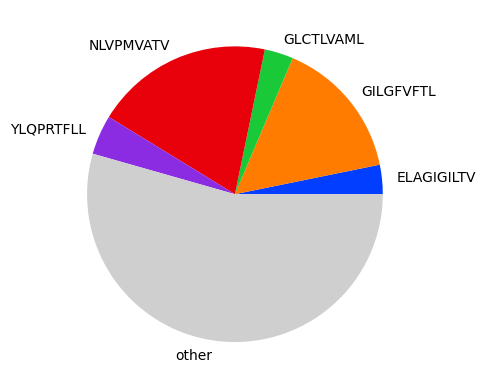

In [63]:
t = pd.DataFrame(data_preped.groupby(str(label+'_high_count_1000'))['cdr3'].count().reset_index())
custom_palette = ml_utils.make_custom_palette(label_high_count_dict[str(label+'_high_count_1000')])
plt.pie(t['cdr3'],labels=t['antigen.epitope_high_count_1000'],colors=custom_palette.values())

NameError: name 'clf' is not defined

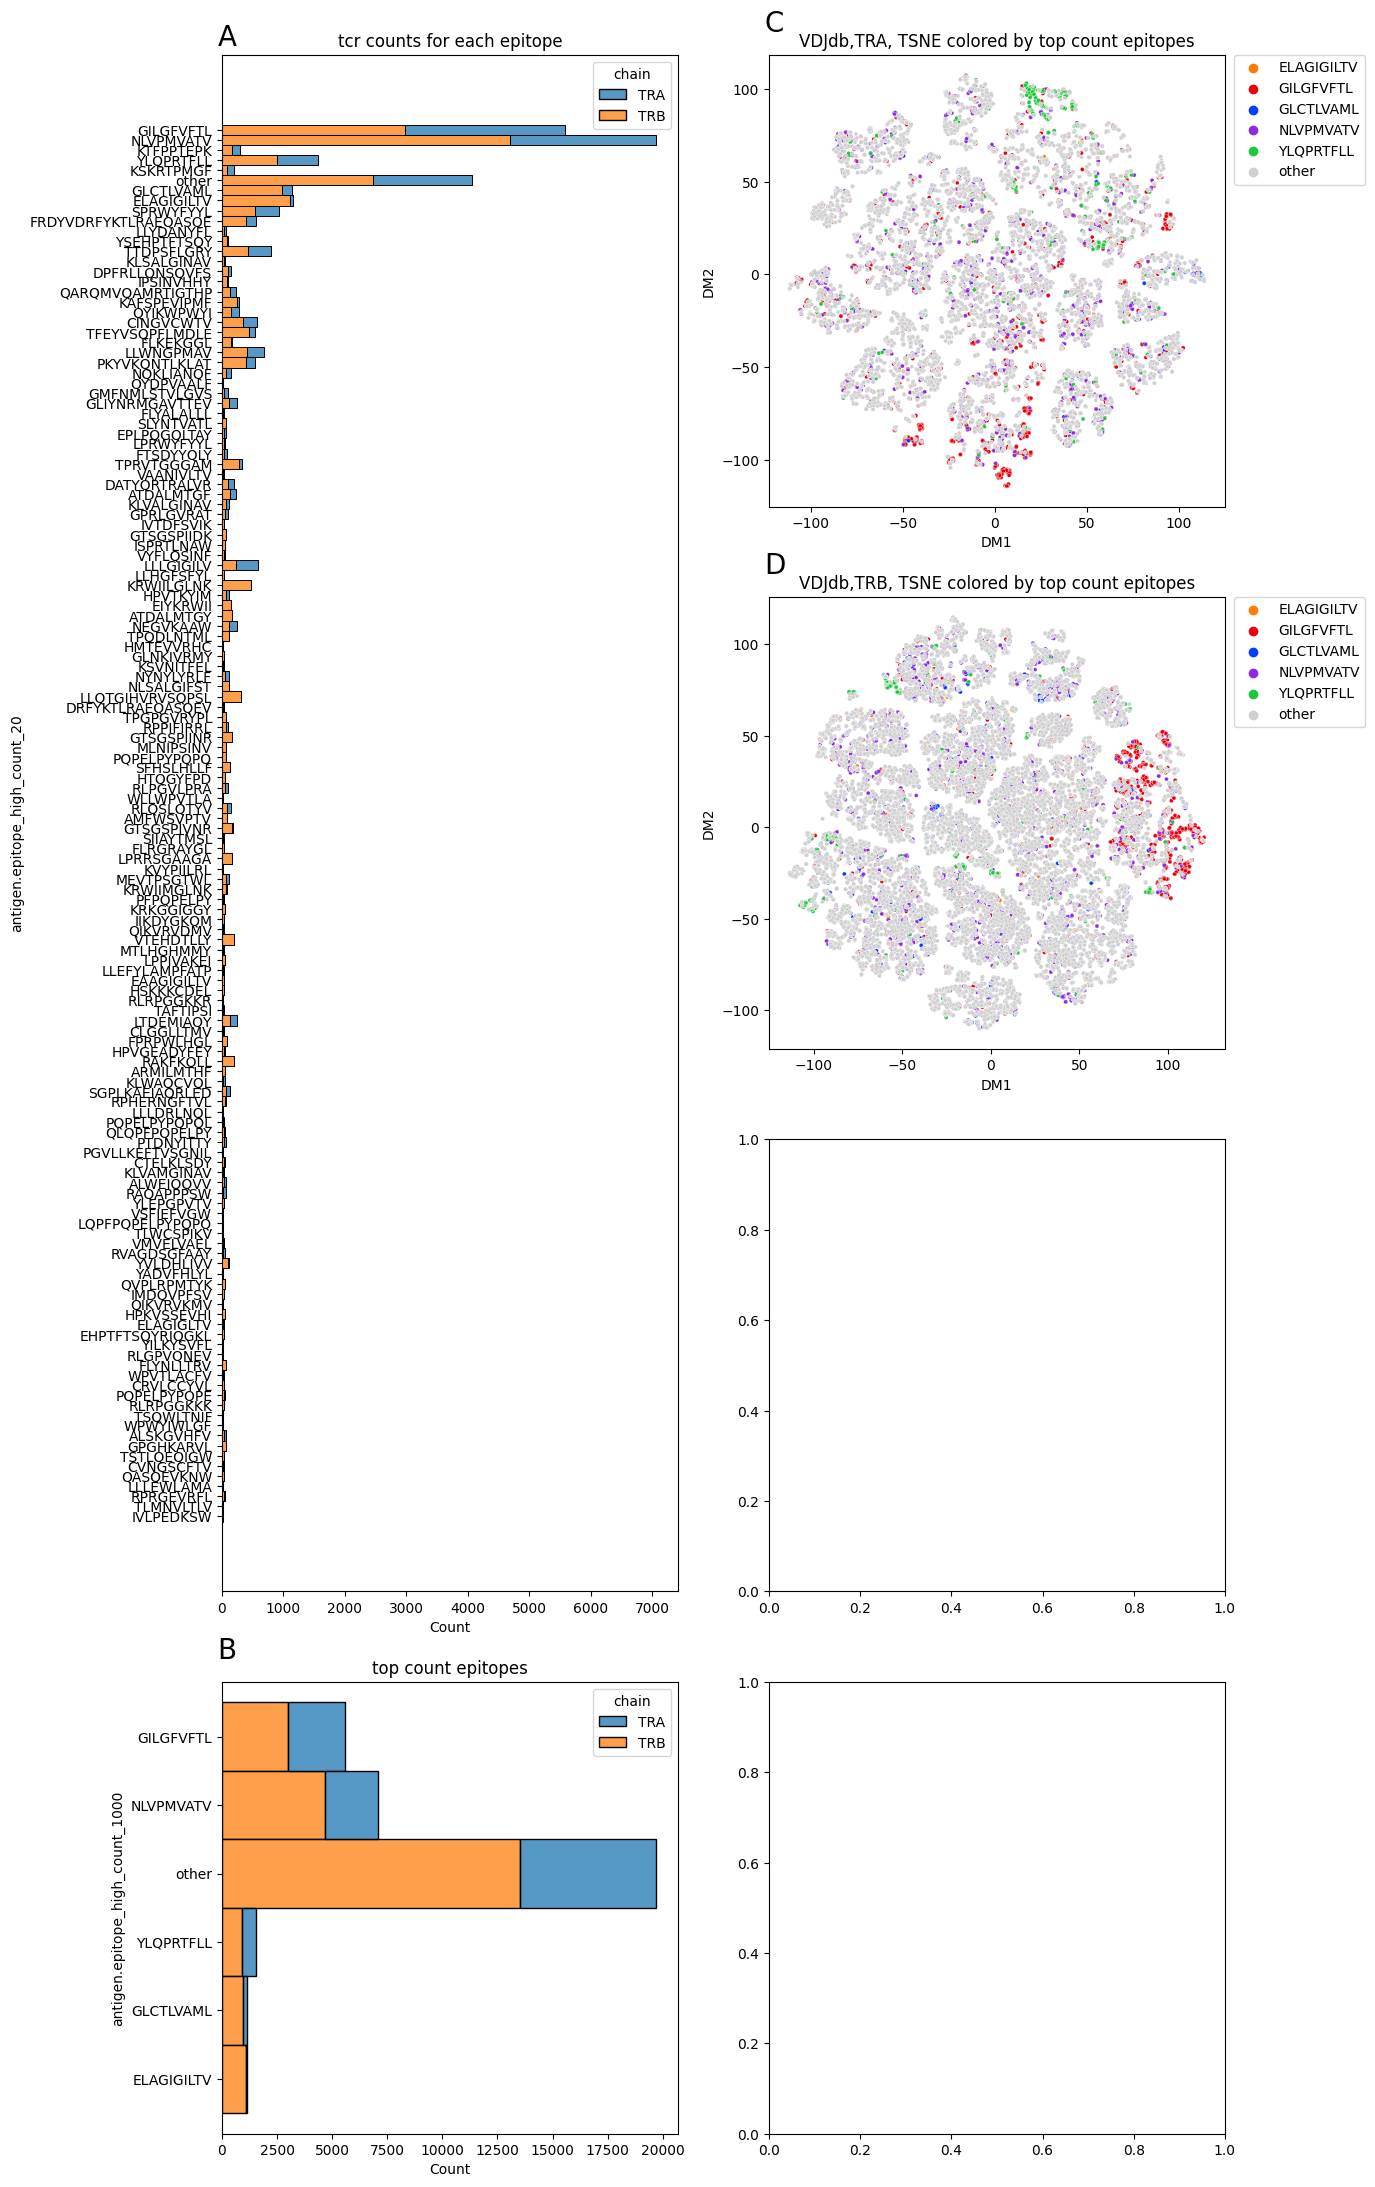

In [65]:

custom_palette = ml_utils.make_custom_palette(label_high_count_dict[str(label+'_high_count_1000')])

fig = plt.figure(figsize=(20,27))

delta_x=-0.01
delta_y=1.1
font_size=20


gs00 = fig.add_gridspec(4, 3)

ax1 = fig.add_subplot(gs00[:3, 0])
ax2 = fig.add_subplot(gs00[3, 0])
ax3 = fig.add_subplot(gs00[0, 1])
ax4 = fig.add_subplot(gs00[1, 1])
ax5 = fig.add_subplot(gs00[2, 1])
ax6 = fig.add_subplot(gs00[3, 1])


sns.histplot(data = data_preped, y = str(label+'_high_count_20'),hue='chain',multiple='stack', ax=ax1)

ax1.text(delta_x, delta_y - 0.08, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('tcr counts for each epitope')

sns.histplot(data = data_preped, y = str(label+'_high_count_1000'),hue='chain',multiple='stack', ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('top count epitopes')

chain = 'TRA'
ml_utils.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label+'_high_count_1000'),f'VDJdb,{chain}, TSNE colored by top count epitopes',custom_palette=custom_palette,ax=ax3)
ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

chain = 'TRB'
ml_utils.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label+'_high_count_1000'), f'VDJdb,{chain}, TSNE colored by top count epitopes',custom_palette=custom_palette,ax=ax4)

ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)



clf.roc_auc('TRA',ax=ax5)

ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)


clf.roc_auc('TRB',ax=ax6)

ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)

#plt.figtext(0.1, 0.001, 'Your-plot-metadata', ha='center', va='center')
#plt.savefig("tcremb_outputs/figures/fig2.svg")
#plt.savefig("tcremb_outputs/figures/fig2.pdf")
#plt.savefig("tcremb_outputs/figures/fig2.png")
plt.show()





In [ ]:

fig = plt.figure(figsize=(20,27))

delta_x=-0.01
delta_y=1.1
font_size=20


gs00 = fig.add_gridspec(4, 3)

ax1 = fig.add_subplot(gs00[:3, 0])
ax2 = fig.add_subplot(gs00[3, 0])
ax3 = fig.add_subplot(gs00[0, 1])
ax4 = fig.add_subplot(gs00[1, 1])
ax5 = fig.add_subplot(gs00[2, 1])
ax6 = fig.add_subplot(gs00[3, 1])


sns.histplot(data = data_preped, y = str(label+'_high_count_20'),hue='chain',multiple='stack', ax=ax1)

ax1.text(delta_x, delta_y - 0.08, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('tcr counts for each epitope')

sns.histplot(data = data_preped, y = str(label+'_high_count_1000'),hue='chain',multiple='stack', ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('top count epitopes')

chain = 'TRA'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label+'_high_count_1000'),f'VDJdb,{chain}, TSNE colored by top count epitopes',custom_palette=custom_palette,ax=ax3)
ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

chain = 'TRB'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label+'_high_count_1000'), f'VDJdb,{chain}, TSNE colored by top count epitopes',custom_palette=custom_palette,ax=ax4)

ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)


label_cl = label+'_high_count_1000'
model_name = 'RF_' + label_cl
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model(model,y_data, X_data , annotation_id, chain,ax=ax5)

ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)


chain = 'TRB'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model(model,y_data, X_data , annotation_id, chain,ax=ax6)

ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)

#plt.figtext(0.1, 0.001, 'Your-plot-metadata', ha='center', va='center')
#plt.savefig("tcremb_outputs/figures/fig2.svg")
#plt.savefig("tcremb_outputs/figures/fig2.pdf")
plt.savefig("tcremb_outputs/figures/fig2.png")
plt.show()





In [ ]:

fig = plt.figure(figsize=(20,27))

delta_x=-0.01
delta_y=1.1
font_size=20


gs00 = fig.add_gridspec(4, 3)

ax1 = fig.add_subplot(gs00[:3, 0])
ax2 = fig.add_subplot(gs00[3, 0])
ax3 = fig.add_subplot(gs00[0, 1])
ax4 = fig.add_subplot(gs00[1, 1])
ax5 = fig.add_subplot(gs00[2, 1])
ax6 = fig.add_subplot(gs00[3, 1])


sns.histplot(data = data_preped, y = str(label+'_high_count_20'),hue='chain',multiple='stack', ax=ax1)

ax1.text(delta_x, delta_y - 0.08, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('tcr counts for each epitope')

sns.histplot(data = data_preped, y = str(label+'_high_count_1000'),hue='chain',multiple='stack', ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('top count epitopes')

chain = 'TRA'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label+'_high_count_1000'),f'VDJdb,{chain}, TSNE colored by top count epitopes',custom_palette=custom_palette,ax=ax3)
ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

chain = 'TRB'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label+'_high_count_1000'), f'VDJdb,{chain}, TSNE colored by top count epitopes',custom_palette=custom_palette,ax=ax4)

ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)


label_cl = label+'_high_count_1000'
model_name = 'RF_' + label_cl
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model_proba(model,y_data, X_data , annotation_id, chain,ax=ax5)

ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)


chain = 'TRB'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model_proba(model,y_data, X_data , annotation_id, chain,ax=ax6)

ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)


#plt.savefig("tcremb_outputs/figures/fig2.svg")
#plt.savefig("tcremb_outputs/figures/fig2.pdf")
#plt.savefig("tcremb_outputs/figures/fig2.png")
plt.show()





In [ ]:
label_high_s_1000

In [ ]:

max_depth = 100
fig = plt.figure(figsize=(20,22))

delta_x=-0.01
delta_y=1.1
font_size=20

gs00 = fig.add_gridspec(4, 3)

ax1 = fig.add_subplot(gs00[:3, 0])
ax2 = fig.add_subplot(gs00[3, 0])
ax3 = fig.add_subplot(gs00[0, 1])
ax4 = fig.add_subplot(gs00[1, 1])
ax5 = fig.add_subplot(gs00[2, 1])
ax6 = fig.add_subplot(gs00[3, 1])

sns.histplot(data = data_preped, y = 'antigen.species',hue='chain',multiple='stack', ax=ax1)

ax1.text(delta_x, delta_y - 0.08, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('tcr counts for each species')

sns.histplot(data = data_preped, y = label_high_s_1000,hue='chain',multiple='stack', ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('top count species')

chain = 'TRA'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label_high_s_1000),f'VDJdb,{chain}, TSNE colored by top antigen.species',ax=ax3)

ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

chain = 'TRB'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label_high_s_1000), f'VDJdb,{chain}, TSNE colored by top antigen.species',ax=ax4)

ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)


label_cl = label_high_s_1000
model_name = 'RF_' + label_cl
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

chain = 'TRA'



y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model_proba(model,y_data, X_data , annotation_id, chain,ax=ax5)

ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

chain = 'TRB'



y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model_proba(model,y_data, X_data , annotation_id, chain,ax=ax6)

ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)


plt.savefig("tcremb_outputs/figures/fig2.2.png")
plt.show()

In [ ]:

fig = plt.figure(figsize=(20,22))

delta_x=-0.01
delta_y=1.1
font_size=20

gs00 = fig.add_gridspec(4, 3)

ax1 = fig.add_subplot(gs00[:3, 0])
ax2 = fig.add_subplot(gs00[3, 0])
ax3 = fig.add_subplot(gs00[0, 1])
ax4 = fig.add_subplot(gs00[1, 1])
ax5 = fig.add_subplot(gs00[2, 1])
ax6 = fig.add_subplot(gs00[3, 1])

sns.histplot(data = data_preped, y = 'antigen.species',hue='chain',multiple='stack', ax=ax1)

ax1.text(delta_x, delta_y - 0.08, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('tcr counts for each species')

sns.histplot(data = data_preped, y = label_high_s_1000,hue='chain',multiple='stack', ax=ax2)

ax2.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('top count species')

chain = 'TRA'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label_high_s_1000),f'VDJdb,{chain}, TSNE colored by top antigen.species',ax=ax3)

ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

chain = 'TRB'
TCRemb_code3.tsne_plot(pd.merge(tcremb.tsne[chain],tcremb.annot[chain]), str(label_high_s_1000), f'VDJdb,{chain}, TSNE colored by top antigen.species',ax=ax4)

ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)


label_cl = label_high_s_1000
model_name = 'RF_' + label_cl
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

chain = 'TRA'
c=5


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model_proba(model,y_data, X_data , annotation_id, chain,ax=ax5)

ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

chain = 'TRB'



y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = clf_model_proba(model,y_data, X_data , annotation_id, chain,ax=ax6)

ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)


plt.savefig("tcremb_outputs/figures/fig2.2.png")
plt.show()

In [ ]:
chain = 'TRA'
TCRemb_code2.tsne_plot(pd.concat([tcremb['tsne'][chain],tcremb['annot'][chain]],axis=1), str(label+'_high_count_1000'), f'VDJdb,{chain}', f'TSNE colored by {str(label+"_high_count_1000")}')

In [ ]:
chain = 'TRB'
TCRemb_code2.tsne_plot(pd.concat([tcremb['tsne'][chain],tcremb['annot'][chain]],axis=1), str(label+'_high_count_1000'), f'VDJdb,{chain}', f'TSNE colored by {str(label+"_high_count_1000")}')

In [ ]:
chain = 'TRB'
TCRemb_code2.tsne_plot(pd.concat([tcremb['tsne'][chain],tcremb['annot'][chain]],axis=1), str(label+'_high_count_200'), f'VDJdb,{chain}', f'TSNE colored by {str(label+"_high_count_200")}')

In [ ]:
model_name = 'RF_label_1000'
label_cl = label+'_high_count_1000'
clsf_dict[model_name]= {'model':{},'roc_auc':{}}

chain = 'TRA'
max_depth = 20


y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)

chain = 'TRB'
max_depth = 20

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]


model = RandomForestClassifier(max_depth=max_depth, random_state=0)
clsf_dict[model_name]['model'][chain], clsf_dict[model_name]['roc_auc'][chain] = TCRemb_code2.clf_model(model,y_data, X_data , annotation_id, chain)


In [ ]:
label_cl = label
model_name = 'KMeans'
threshold = 0.6
clstr_dict[model_name]= {'binom_res':{},'clstr_metrics':{},'binom_res_train':{},'clstr_metrics_train':{}}
tcremb['clstr_labels'][model_name]={}




chain = 'TRA'
n_clusters = 5295
random_state = 8

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]#.drop(annotation_id, axis=1, errors = 'ignore')

model =  KMeans(n_clusters=n_clusters, random_state=random_state)
tcremb['clstr_labels'][model_name][chain] = TCRemb_code2.clstr_model(model, X_data , annotation_id)

clstr_dict[model_name]['binom_res'][chain] = TCRemb_code2.binominal_test(pd.merge(tcremb['clstr_labels'][model_name][chain],tcremb['annot'][chain]), 'cluster', label_cl)
clstr_dict[model_name]['binom_res'][chain]['enriched_clstr'] =clstr_dict[model_name]['binom_res'][chain].apply(lambda x:1 
                                                                                                               if (x.fraction_matched>=threshold)
                                                                                                               and (x.total_cluster>2) else 0,axis=1)
clstr_dict[model_name]['clstr_metrics'][chain] = TCRemb_code2.clstr_metrics(tcremb['annot'][chain][label_cl],tcremb['clstr_labels'][model_name][chain]['cluster'])



tcremb['clstr_labels'][model_name][chain] = tcremb['clstr_labels'][model_name][chain].merge(clstr_dict[model_name]['binom_res'][chain].rename({label_cl:'label_cluster'},axis=1)
                                                                                            , on='cluster',how='left').sort_values(annotation_id).reset_index(drop=True)

print('mean fraction_matched: ' + str(statistics.mean(clstr_dict[model_name]['binom_res'][chain]['fraction_matched'])))
print('median fraction_matched: ' + str(statistics.median(clstr_dict[model_name]['binom_res'][chain]['fraction_matched'])))
print(clstr_dict[model_name]['clstr_metrics'][chain])


sns.histplot(tcremb['clstr_labels'][model_name][chain]['enriched_clstr'].astype(str))
plt.title('count of tcrs in enriched clusters')
TCRemb_code2.tsne_plot(pd.merge(tcremb['tsne'][chain],tcremb['clstr_labels'][model_name][chain],on=annotation_id), 'enriched_clstr', f'10x ,{chain}', f'TSNE colored by enriched_clstr', True)

chain = 'TRB'
n_clusters = 10616
random_state = 8

y_data = tcremb['annot'][chain][label_cl]
X_data = tcremb['pca'][chain]#.drop(annotation_id, axis=1, errors = 'ignore')

model =  KMeans(n_clusters=n_clusters, random_state=random_state)
tcremb['clstr_labels'][model_name][chain] = TCRemb_code2.clstr_model(model, X_data , annotation_id)

clstr_dict[model_name]['binom_res'][chain] = TCRemb_code2.binominal_test(pd.merge(tcremb['clstr_labels'][model_name][chain],tcremb['annot'][chain]), 'cluster', label_cl)
clstr_dict[model_name]['binom_res'][chain]['enriched_clstr'] =clstr_dict[model_name]['binom_res'][chain].apply(lambda x:1 
                                                                                                               if (x.fraction_matched>=threshold)
                                                                                                               and (x.total_cluster>2) else 0,axis=1)
clstr_dict[model_name]['clstr_metrics'][chain] = TCRemb_code2.clstr_metrics(tcremb['annot'][chain][label_cl],tcremb['clstr_labels'][model_name][chain]['cluster'])



tcremb['clstr_labels'][model_name][chain] = tcremb['clstr_labels'][model_name][chain].merge(clstr_dict[model_name]['binom_res'][chain].rename({label_cl:'label_cluster'},axis=1)
                                                                                            , on='cluster',how='left').sort_values(annotation_id).reset_index(drop=True)

print('mean fraction_matched: ' + str(statistics.mean(clstr_dict[model_name]['binom_res'][chain]['fraction_matched'])))
print('median fraction_matched: ' + str(statistics.median(clstr_dict[model_name]['binom_res'][chain]['fraction_matched'])))
print(clstr_dict[model_name]['clstr_metrics'][chain])


sns.histplot(tcremb['clstr_labels'][model_name][chain]['enriched_clstr'].astype(str))
plt.title('count of tcrs in enriched clusters')
TCRemb_code2.tsne_plot(pd.merge(tcremb['tsne'][chain],tcremb['clstr_labels'][model_name][chain],on=annotation_id), 'enriched_clstr', f'10x ,{chain}', f'TSNE colored by enriched_clstr', True)
